In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install git+https://github.com/rusty1s/pytorch_geometric.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 13.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rusty1s/pytorch_geometric.git to /tmp/pip-req-build-iy0vsoao
  Running command git clone --filter=blob:none --quiet https://github.com/rusty1s/pytorch_geometric.git /tmp/pip-req-build-iy0vsoao
  Resolved https://github.com/rusty1s/pytorch_geometric.git to commit 7ac4654db727df73d1443c5102020abe859e5eb6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from math import sqrt
import math

from torch_geometric.datasets import TUDataset

import torch as th
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn.parameter import Parameter
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear, LayerNorm
from sklearn import metrics
from scipy.spatial.distance import hamming
import statistics
import pandas
from time import perf_counter
from IPython.core.display import deepcopy
from torch_geometric.nn import MessagePassing
import copy
from torch.nn import ReLU, Sequential
from torch import sigmoid
from itertools import chain
from time import perf_counter
from torch_geometric.data import Data, Batch, Dataset
from functools import partial
from torch_geometric.utils import to_networkx
from torch_geometric.utils import remove_self_loops
from typing import Callable, Union, Optional
#from torch_geometric.utils.num_nodes import maybe_num_nodes
import networkx as nx
from typing import List, Tuple, Dict
from collections import Counter
import statistics
import tqdm
import csv


from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch_geometric.nn as gnn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


In [5]:
Explainability_name = 'CF2'
Task_name = 'Graph Classification'
Model_Name = "DIFFPOOL"
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
DataSet_name = "MUTAG"

File_Name = Model_Name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [6]:
#train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=0, shuffle=True)
#print("Number of Training Graphs: ", len(train_dataset))
#print("Number of Test Graphs: ", len(test_dataset))

df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
    train_dataset.append(dataset[index])
for index in read_test_list_indexes:
    test_dataset.append(dataset[index])


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]
Number of training graphs: 150
Number of test graphs: 38


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [8]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)

import DIFFPOOL as diffpool_model
GNN_Model = diffpool_model.DIFFPOOL_Model(embedding_input_dim=7, embedding_num_block_layers=1, embedding_hid_dim=64,
                                          new_feature_size=64, assignment_input_dim=7, assignment_num_block_layers=1,
                                          assignment_hid_dim=64, max_number_of_nodes=256, prediction_hid_layers=[50],
                                          concat_neighborhood=False, num_classes=2, Weight_Initializer=1, Bias=classifier_bias,
                                          dropout_rate=0, normalize_graphsage=False, aggregation="mean", act_fun="ReLu",
                                          concat_diffpools_outputs=True, num_pooling=1, pooling="mean")

ReLu is Selected.


In [9]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [10]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch

In [11]:
def visualize_losses(GNN_Model_losses, epoch_history):
    GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(" Loss in Epoch: " + str(epoch_history))

    ax.plot(GNN_Model_losses_list, color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()


In [12]:
def train_step():
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []
    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in train_dataloader:

        concatination_list_of_poolings, softmaxed_h2 = GNN_Model(batch_of_graphs, None)
        batch_loss = loss_calculations(softmaxed_h2, batch_of_graphs.y)
        Pred_Labels.extend(softmaxed_h2.argmax(dim=1).detach().tolist())
        #print('passed')
        GNN_Model_loss_batch.append(batch_loss)

        Real_Labels.extend(batch_of_graphs.y.detach().tolist())

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)

In [13]:
GNN_Model_training_time_per_epoch = []
GNN_Model_training_Acc_per_epoch = []
def train(EPOCHS, load_index):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        start_generation = perf_counter()
        GNN_Model_training_loss, training_acc = train_step()
        GNN_Model_training_time_per_epoch.append(perf_counter() - start_generation)
        GNN_Model_training_Acc_per_epoch.append(training_acc)
        print(f'Epoch: {epoch+1:03d}, Model Loss: {GNN_Model_training_loss:.4f}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        #break

        if (epoch + load_index + 1) % 50 == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        if (epoch + load_index + 1) % 100 == 0 and epoch > 0:
            torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")



Epoch: 001, Model Loss: 0.6908
Epoch: 002, Model Loss: 0.6817
Epoch: 003, Model Loss: 0.6730
Epoch: 004, Model Loss: 0.6630
Epoch: 005, Model Loss: 0.6520
Epoch: 006, Model Loss: 0.6404
Epoch: 007, Model Loss: 0.6296
Epoch: 008, Model Loss: 0.6215
Epoch: 009, Model Loss: 0.6178
Epoch: 010, Model Loss: 0.6179
Epoch: 011, Model Loss: 0.6188
Epoch: 012, Model Loss: 0.6183
Epoch: 013, Model Loss: 0.6167
Epoch: 014, Model Loss: 0.6151
Epoch: 015, Model Loss: 0.6143
Epoch: 016, Model Loss: 0.6141
Epoch: 017, Model Loss: 0.6138
Epoch: 018, Model Loss: 0.6129
Epoch: 019, Model Loss: 0.6117
Epoch: 020, Model Loss: 0.6106
Epoch: 021, Model Loss: 0.6097
Epoch: 022, Model Loss: 0.6087
Epoch: 023, Model Loss: 0.6074
Epoch: 024, Model Loss: 0.6059
Epoch: 025, Model Loss: 0.6041
Epoch: 026, Model Loss: 0.6015
Epoch: 027, Model Loss: 0.5982
Epoch: 028, Model Loss: 0.5945
Epoch: 029, Model Loss: 0.5895
Epoch: 030, Model Loss: 0.5830
Epoch: 031, Model Loss: 0.5745
Epoch: 032, Model Loss: 0.5643
Epoch: 0

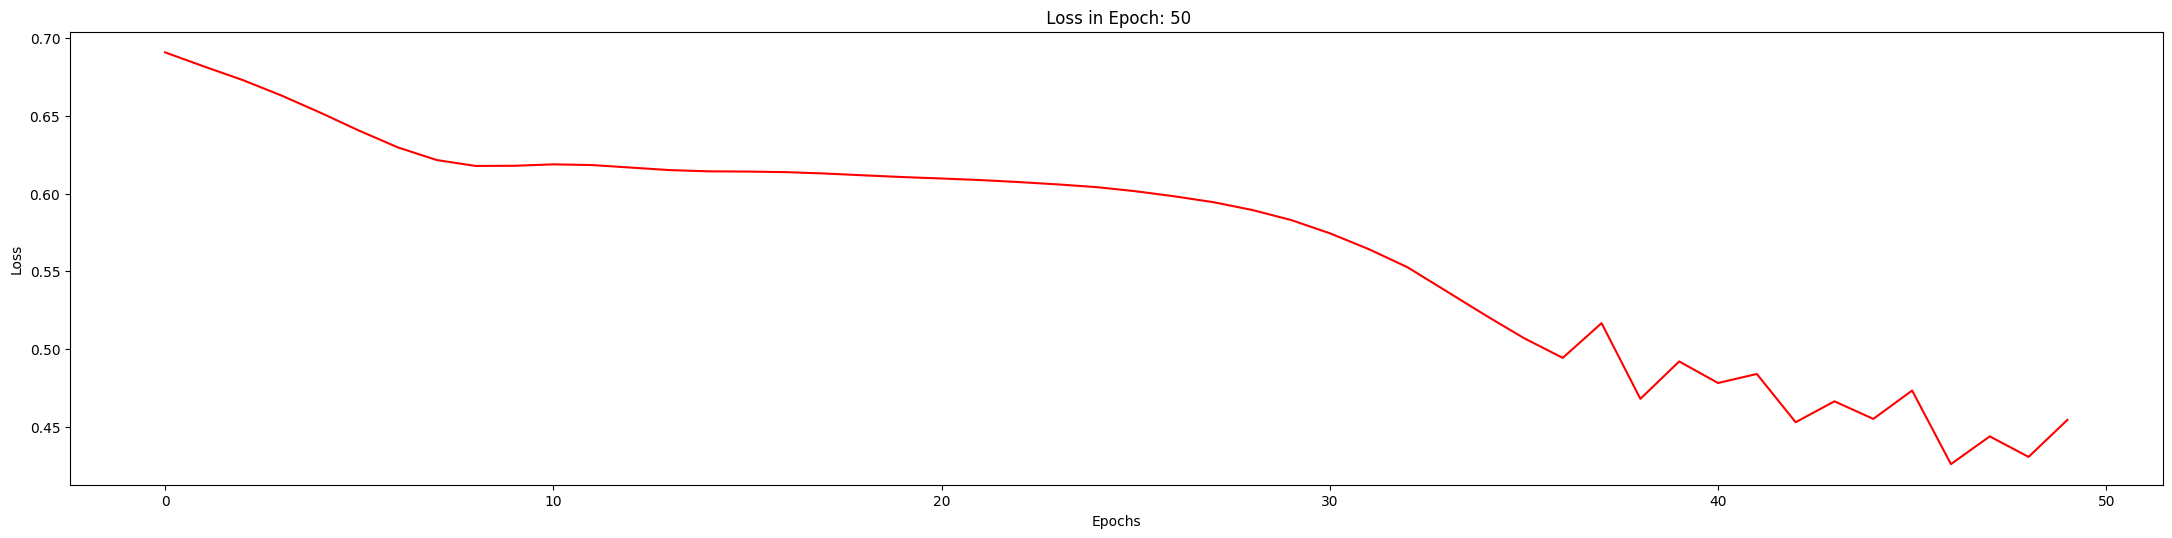

Epoch: 051, Model Loss: 0.4274
Epoch: 052, Model Loss: 0.4232
Epoch: 053, Model Loss: 0.4266
Epoch: 054, Model Loss: 0.4272
Epoch: 055, Model Loss: 0.4445
Epoch: 056, Model Loss: 0.4069
Epoch: 057, Model Loss: 0.4162
Epoch: 058, Model Loss: 0.4162
Epoch: 059, Model Loss: 0.4312
Epoch: 060, Model Loss: 0.4165
Epoch: 061, Model Loss: 0.4066
Epoch: 062, Model Loss: 0.4124
Epoch: 063, Model Loss: 0.4325
Epoch: 064, Model Loss: 0.4113
Epoch: 065, Model Loss: 0.4061
Epoch: 066, Model Loss: 0.4108
Epoch: 067, Model Loss: 0.4270
Epoch: 068, Model Loss: 0.4149
Epoch: 069, Model Loss: 0.4035
Epoch: 070, Model Loss: 0.4115
Epoch: 071, Model Loss: 0.4156
Epoch: 072, Model Loss: 0.4396
Epoch: 073, Model Loss: 0.3986
Epoch: 074, Model Loss: 0.4226
Epoch: 075, Model Loss: 0.4146
Epoch: 076, Model Loss: 0.4161
Epoch: 077, Model Loss: 0.4485
Epoch: 078, Model Loss: 0.3962
Epoch: 079, Model Loss: 0.4235
Epoch: 080, Model Loss: 0.4208
Epoch: 081, Model Loss: 0.4095
Epoch: 082, Model Loss: 0.4279
Epoch: 0

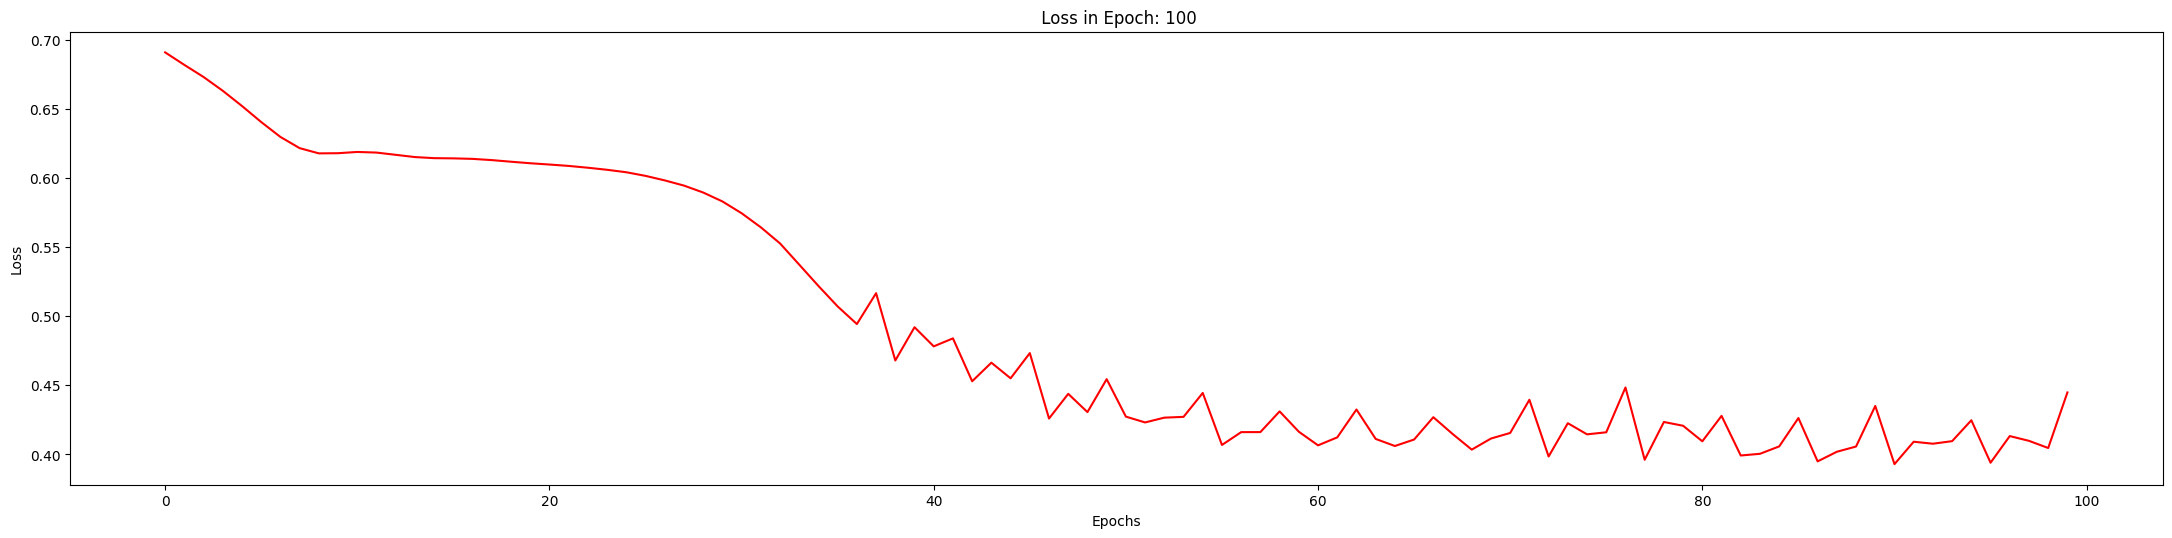

Epoch: 101, Model Loss: 0.3928
Epoch: 102, Model Loss: 0.4133
Epoch: 103, Model Loss: 0.4164
Epoch: 104, Model Loss: 0.4055
Epoch: 105, Model Loss: 0.4183
Epoch: 106, Model Loss: 0.3998
Epoch: 107, Model Loss: 0.3958
Epoch: 108, Model Loss: 0.4017
Epoch: 109, Model Loss: 0.4022
Epoch: 110, Model Loss: 0.4163
Epoch: 111, Model Loss: 0.3917
Epoch: 112, Model Loss: 0.4049
Epoch: 113, Model Loss: 0.4025
Epoch: 114, Model Loss: 0.4098
Epoch: 115, Model Loss: 0.4012
Epoch: 116, Model Loss: 0.3929
Epoch: 117, Model Loss: 0.3997
Epoch: 118, Model Loss: 0.4042
Epoch: 119, Model Loss: 0.4122
Epoch: 120, Model Loss: 0.3908
Epoch: 121, Model Loss: 0.4049
Epoch: 122, Model Loss: 0.4011
Epoch: 123, Model Loss: 0.4354
Epoch: 124, Model Loss: 0.3914
Epoch: 125, Model Loss: 0.4079
Epoch: 126, Model Loss: 0.4110
Epoch: 127, Model Loss: 0.4015
Epoch: 128, Model Loss: 0.4392
Epoch: 129, Model Loss: 0.3918
Epoch: 130, Model Loss: 0.4101
Epoch: 131, Model Loss: 0.4164
Epoch: 132, Model Loss: 0.4081
Epoch: 1

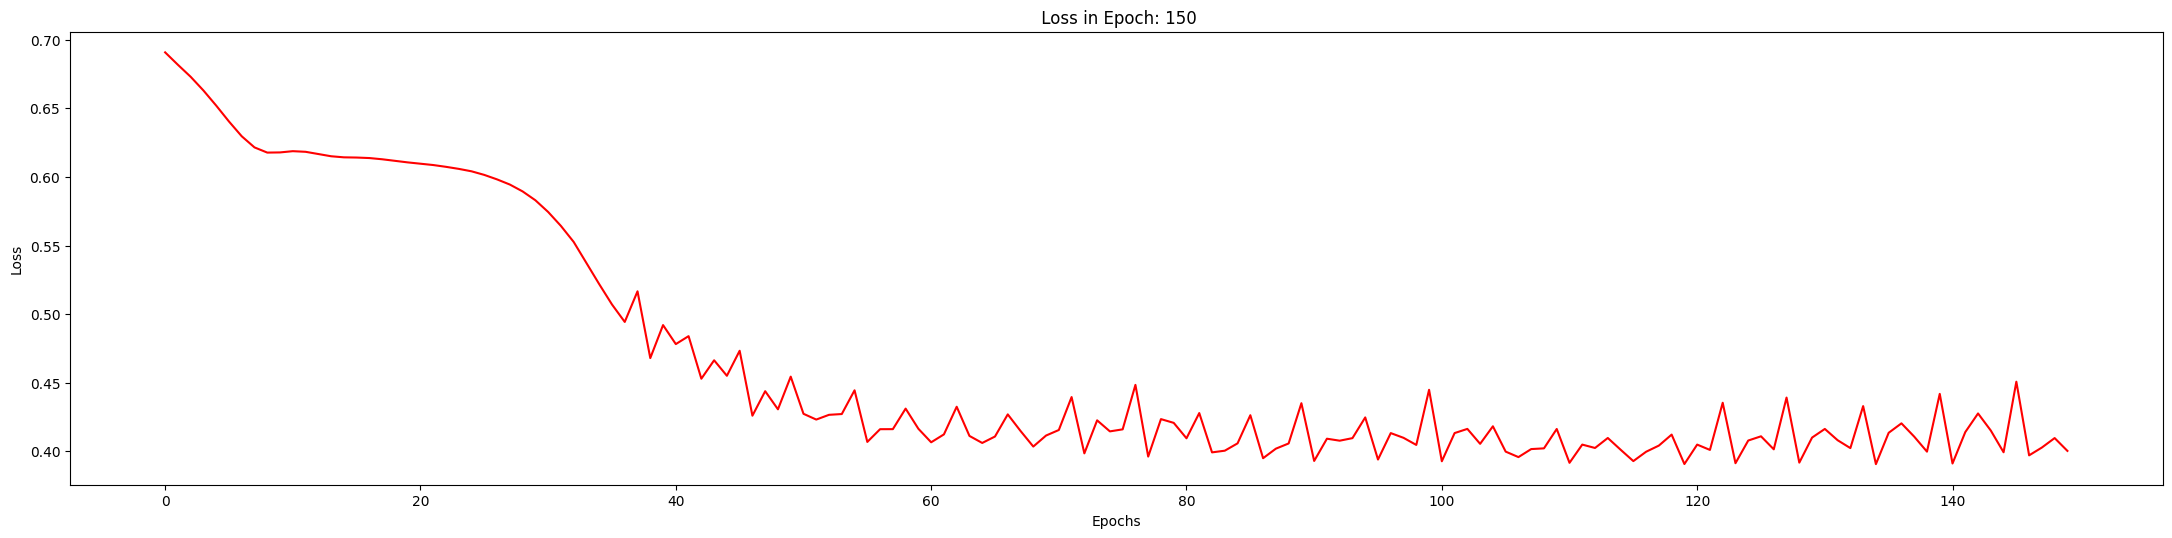

Epoch: 151, Model Loss: 0.4191
Epoch: 152, Model Loss: 0.3937
Epoch: 153, Model Loss: 0.3949
Epoch: 154, Model Loss: 0.3985
Epoch: 155, Model Loss: 0.4033
Epoch: 156, Model Loss: 0.4017
Epoch: 157, Model Loss: 0.3890
Epoch: 158, Model Loss: 0.4010
Epoch: 159, Model Loss: 0.3981
Epoch: 160, Model Loss: 0.4312
Epoch: 161, Model Loss: 0.3884
Epoch: 162, Model Loss: 0.4077
Epoch: 163, Model Loss: 0.4099
Epoch: 164, Model Loss: 0.4000
Epoch: 165, Model Loss: 0.4424
Epoch: 166, Model Loss: 0.3921
Epoch: 167, Model Loss: 0.4102
Epoch: 168, Model Loss: 0.4220
Epoch: 169, Model Loss: 0.4199
Epoch: 170, Model Loss: 0.4075
Epoch: 171, Model Loss: 0.4042
Epoch: 172, Model Loss: 0.4227
Epoch: 173, Model Loss: 0.3864
Epoch: 174, Model Loss: 0.4045
Epoch: 175, Model Loss: 0.4012
Epoch: 176, Model Loss: 0.4033
Epoch: 177, Model Loss: 0.4078
Epoch: 178, Model Loss: 0.3864
Epoch: 179, Model Loss: 0.3966
Epoch: 180, Model Loss: 0.3949
Epoch: 181, Model Loss: 0.4152
Epoch: 182, Model Loss: 0.3919
Epoch: 1

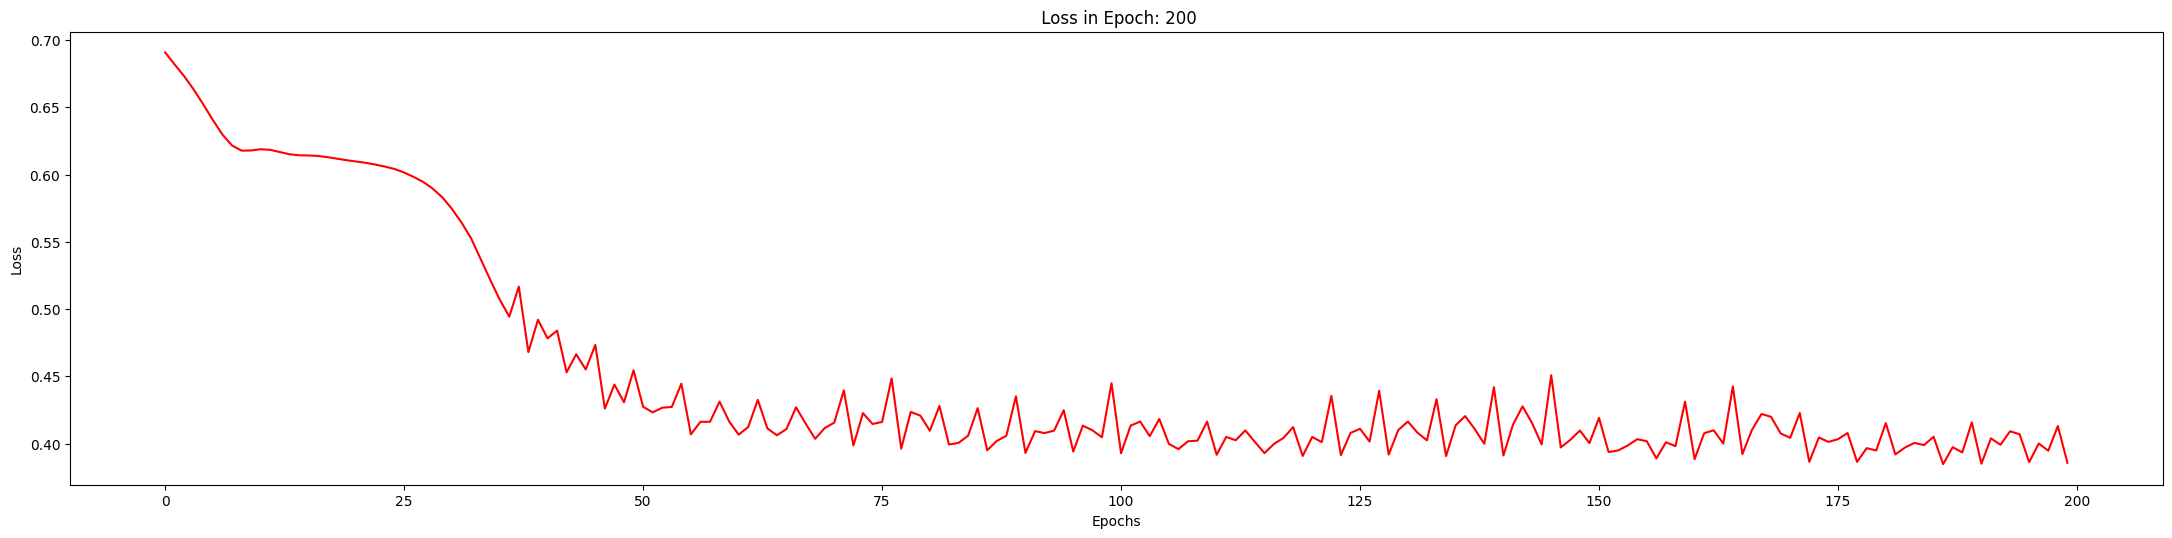

Epoch: 201, Model Loss: 0.3990
Epoch: 202, Model Loss: 0.3949
Epoch: 203, Model Loss: 0.4264
Epoch: 204, Model Loss: 0.4067
Epoch: 205, Model Loss: 0.3947
Epoch: 206, Model Loss: 0.4061
Epoch: 207, Model Loss: 0.3964
Epoch: 208, Model Loss: 0.4170
Epoch: 209, Model Loss: 0.3929
Epoch: 210, Model Loss: 0.3962
Epoch: 211, Model Loss: 0.3987
Epoch: 212, Model Loss: 0.4000
Epoch: 213, Model Loss: 0.4058
Epoch: 214, Model Loss: 0.3823
Epoch: 215, Model Loss: 0.3997
Epoch: 216, Model Loss: 0.3915
Epoch: 217, Model Loss: 0.4235
Epoch: 218, Model Loss: 0.3931
Epoch: 219, Model Loss: 0.3994
Epoch: 220, Model Loss: 0.4038
Epoch: 221, Model Loss: 0.3960
Epoch: 222, Model Loss: 0.4166
Epoch: 223, Model Loss: 0.3860
Epoch: 224, Model Loss: 0.3991
Epoch: 225, Model Loss: 0.3945
Epoch: 226, Model Loss: 0.4094
Epoch: 227, Model Loss: 0.4067
Epoch: 228, Model Loss: 0.3842
Epoch: 229, Model Loss: 0.4017
Epoch: 230, Model Loss: 0.3921
Epoch: 231, Model Loss: 0.4148
Epoch: 232, Model Loss: 0.3982
Epoch: 2

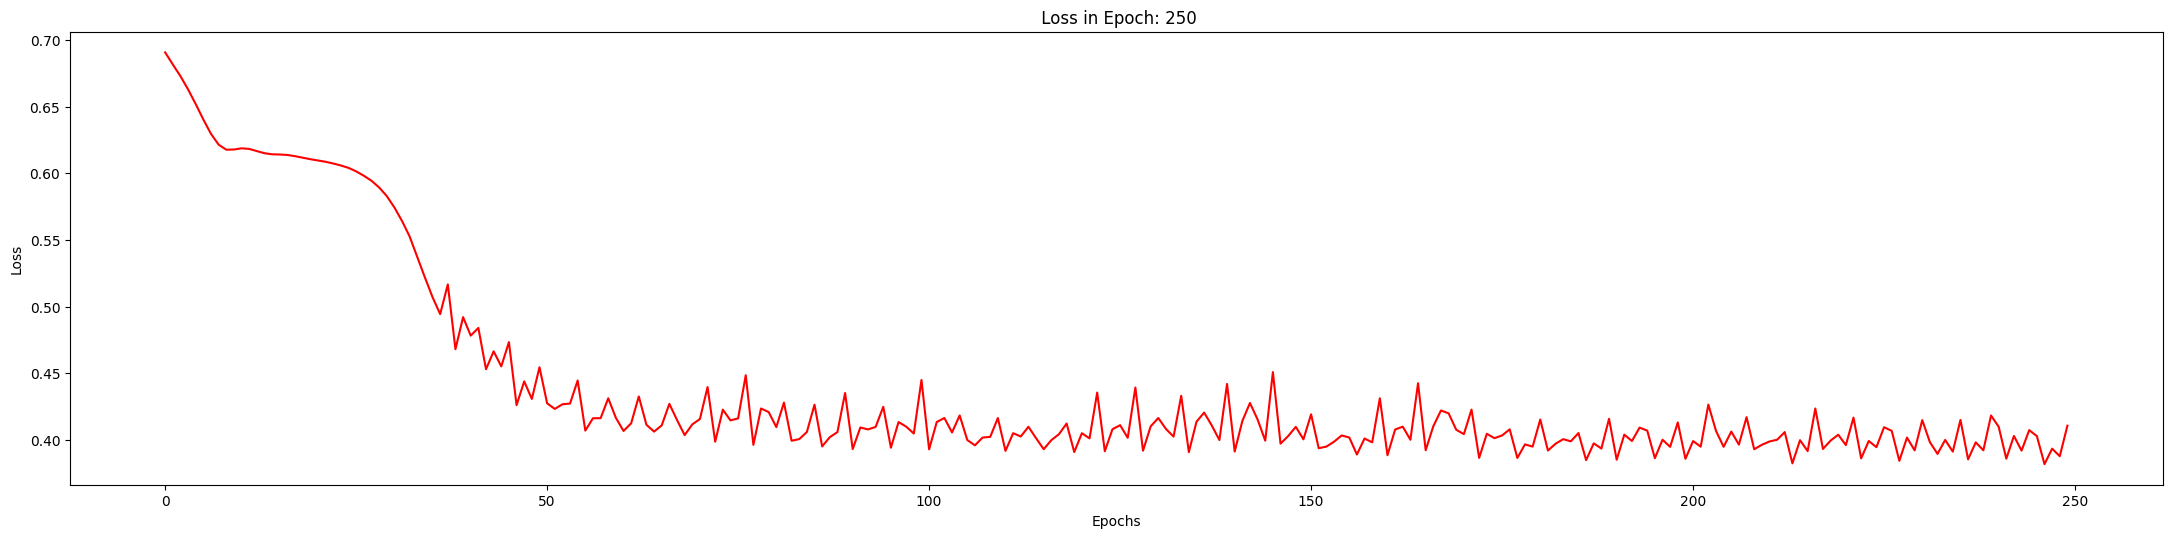

Epoch: 251, Model Loss: 0.3868
Epoch: 252, Model Loss: 0.3897
Epoch: 253, Model Loss: 0.3886
Epoch: 254, Model Loss: 0.4230
Epoch: 255, Model Loss: 0.4035
Epoch: 256, Model Loss: 0.3906
Epoch: 257, Model Loss: 0.4114
Epoch: 258, Model Loss: 0.3964
Epoch: 259, Model Loss: 0.4023
Epoch: 260, Model Loss: 0.4124
Epoch: 261, Model Loss: 0.3839
Epoch: 262, Model Loss: 0.3997
Epoch: 263, Model Loss: 0.4004
Epoch: 264, Model Loss: 0.3927
Epoch: 265, Model Loss: 0.4145
Epoch: 266, Model Loss: 0.3912
Epoch: 267, Model Loss: 0.3891
Epoch: 268, Model Loss: 0.3972
Epoch: 269, Model Loss: 0.3875
Epoch: 270, Model Loss: 0.4120
Epoch: 271, Model Loss: 0.3855
Epoch: 272, Model Loss: 0.3919
Epoch: 273, Model Loss: 0.3900
Epoch: 274, Model Loss: 0.4193
Epoch: 275, Model Loss: 0.4079
Epoch: 276, Model Loss: 0.3846
Epoch: 277, Model Loss: 0.4065
Epoch: 278, Model Loss: 0.3924
Epoch: 279, Model Loss: 0.4075
Epoch: 280, Model Loss: 0.4108
Epoch: 281, Model Loss: 0.3825
Epoch: 282, Model Loss: 0.4002
Epoch: 2

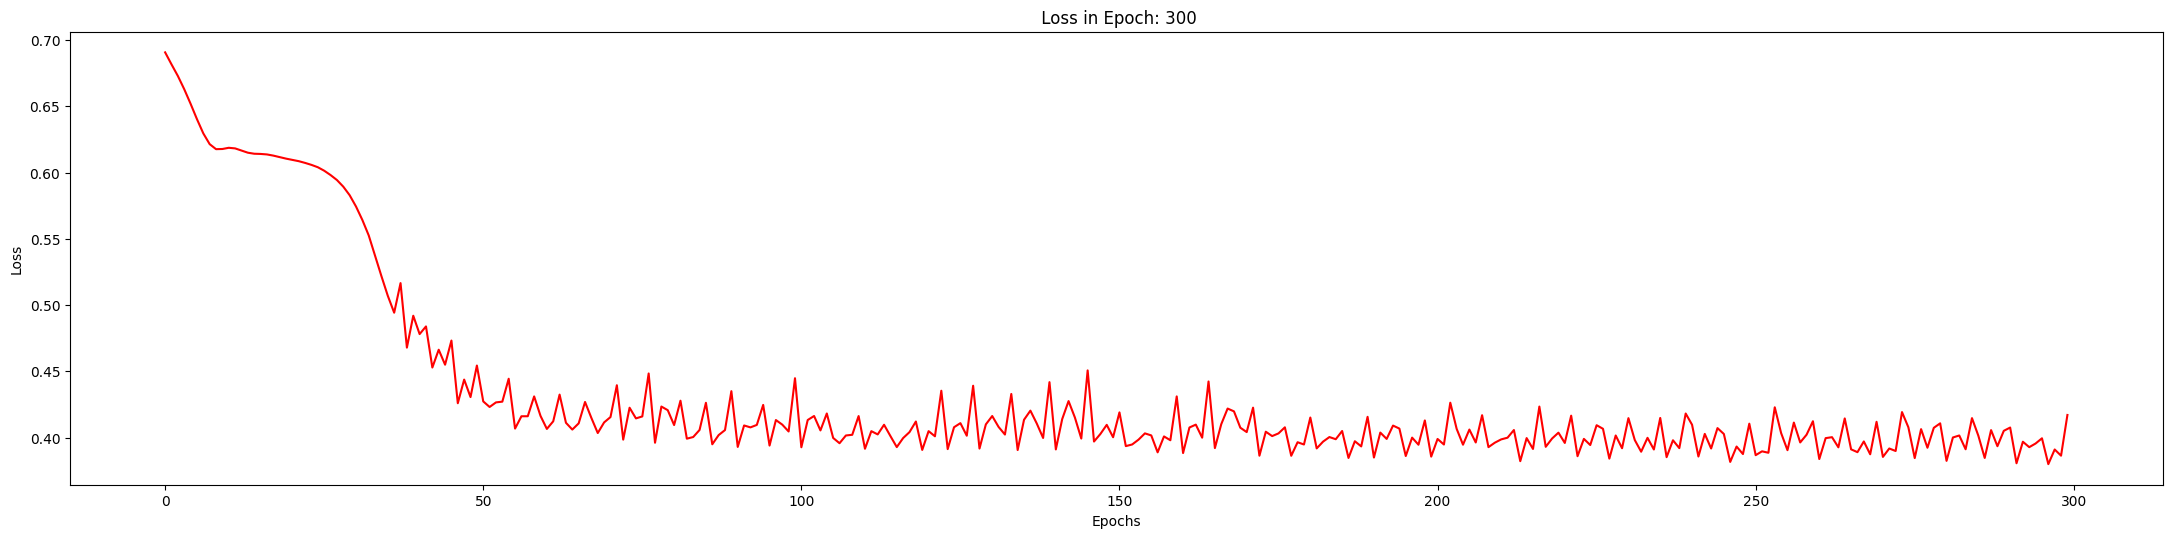

In [14]:
EPOCHS = 300
load_index = 0

train(EPOCHS, load_index)

In [15]:
def GNN_Model_test(test_loader):
    predictions = []
    GNN_Model.eval()

    correct = 0
    for batch_of_graphs in test_loader:

        concatination_list_of_poolings, softmaxed_h2 = GNN_Model(batch_of_graphs, None)
        GNN_Model_test_pred = softmaxed_h2.argmax(dim=1)
        predictions.append(GNN_Model_test_pred.tolist()[0])

        correct += int((GNN_Model_test_pred == batch_of_graphs.y).sum())

    return correct / len(test_dataset), predictions

In [16]:
GNN_Model_test_acc, predictions = GNN_Model_test(test_dataset)
print(f'Test Accuracy: {GNN_Model_test_acc:.4f}')

Test Accuracy: 0.6579


In [17]:
def instance_time(test_dataset):
    instance_based_time = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_dataset:
        start_generation = perf_counter()

        concatination_list_of_poolings, softmaxed_h2 = GNN_Model(batched_data, None)
        GNN_test_pred = softmaxed_h2.argmax(dim=1)
        consumed_time = perf_counter() - start_generation
        instance_based_time.append(consumed_time)
    return instance_based_time

In [18]:
samples_time = instance_time(test_dataset)
print(f'Test Instance based Time: {samples_time}')

Test Instance based Time: [0.00850112699993133, 0.0035242799999650742, 0.002583525999966696, 0.002542662999985623, 0.0025177810000514, 0.002615882999975838, 0.0025145540000721667, 0.0038861699999870325, 0.0026662049999686133, 0.0025904330000230402, 0.0025152860000616784, 0.002816251000012926, 0.0025185239999245823, 0.002544034999914402, 0.002547260000028473, 0.002482390999944073, 0.002514714999961143, 0.0025170540000090114, 0.0031882420000783895, 0.002801136000016413, 0.002603237000016634, 0.0024910359999239517, 0.0025695839999571035, 0.002561924000019644, 0.0025329000000056112, 0.002466005999963272, 0.0027032709999730287, 0.0027019969999173554, 0.0025104659999897194, 0.002511701000003086, 0.00248532700004489, 0.0024791179999965607, 0.0024440500000082466, 0.0024839530000235754, 0.002494625999929667, 0.002508612999918114, 0.002452693000009276, 0.0025376059999189238]


In [19]:
print(predictions)
real_labels = []
for graph in test_dataset:
    real_labels.append(graph.y.detach().tolist()[0])
print(real_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]


In [ ]:
Auc_Roc = metrics.roc_auc_score(real_labels, predictions)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predictions)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predictions, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predictions, normalize=False)
print("Auc_Roc: ", Auc_Roc, "Auc_Prc: ", Auc_Prc, "Acc: ", Acc, "Acc2: ", Acc2)

Auc_Roc:  0.7113095238095238 Auc_Prc:  0.8510338345864662 Acc:  0.7105263157894737 Acc2:  27


In [22]:
class CF2_Explainer(torch.nn.Module):
    def __init__(self, graph, GNN_Model, reset_mask_to_None):
        super(CF2_Explainer, self).__init__()

        self.graph = graph
        self.num_nodes = len(self.graph.x)
        self.num_edges = len(self.graph.edge_index[0])
        self.GNN_Model = GNN_Model
        if reset_mask_to_None == True:
            self.clear_masks(self.GNN_Model)

        self.adj_mask = self.adj_mask_creation()


    def forward(self):
        masked_adj = self.get_masked_adj()

        concatination_list_of_poolings, pred_factual = self.GNN_Model(self.graph, masked_adj.tolist())  # factual

        concatination_list_of_poolings, pred_c_factual = self.GNN_Model(self.graph, (torch.ones_like(masked_adj) - masked_adj).tolist())


        return pred_factual, pred_c_factual

    def apply_masks(self, model, mask):
        loop_mask = self.graph.edge_index[0] != self.graph.edge_index[1]
        for i, module in enumerate(model.modules()):
            if isinstance(module, MessagePassing):
                mask = Parameter(mask)
                module._explain = True
                module._edge_mask = mask
                module._loop_mask = loop_mask
                module._apply_sigmoid = False

    def clear_masks(self, model):
        for module in model.modules():
            if isinstance(module, MessagePassing):
                module.explain = False
                module._edge_mask = None
                module._loop_mask = True
                module._apply_sigmoid = False
        return module

    def loss(self, pred_factual, pred_c_factual, original_pred, gamma_coeff, lambda_coeff, alpha_coeff):

        relu = torch.nn.ReLU()
        strength_factual = relu(original_pred + gamma_coeff - pred_factual)  # factual
        strength_c_factual = relu(original_pred + pred_c_factual - gamma_coeff)  # counterfactual

        masked_adj = self.get_masked_adj()

        L1 = torch.linalg.norm(masked_adj[0])
        strength_loss = lambda_coeff * (alpha_coeff * strength_factual + (1 - alpha_coeff) * strength_c_factual)
        loss = L1 + strength_loss
        #print("L1: ", L1, "    ", " Strength_Loss: ", strength_loss)
        return strength_factual, strength_c_factual, L1, loss



    def adj_mask_creation(self):
        mask_for_adj = torch.nn.Parameter(torch.FloatTensor(self.num_edges))
        std = torch.nn.init.calculate_gain("relu") * math.sqrt(2.0 / (self.num_nodes + self.num_nodes))
        with torch.no_grad():
            mask_for_adj.normal_(1.0, std)
        return mask_for_adj




    def get_masked_adj(self):

        sym_mask = torch.sigmoid(self.adj_mask)
        sym_mask = (sym_mask + sym_mask.t()) / 2

        mask = torch.reshape(sym_mask, (-1, ))
        #print(mask)


        return mask



#GNN_Model2 = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=7, hidden_dim=7, output_dim=2, num_hid_layers=2, Bias=True, act_fun='eLu', Weight_Initializer=1, dropout_rate=0.1)
#cf2_explainer_example = CF2_Explainer(graph=test_dataset[0], GNN_Model=GNN_Model2, reset_mask_to_None=True)
#pred_factual, pred_counter_factual = cf2_explainer_example.forward()
#print("pred_factual: ", pred_factual)
#print("pred_counter_factual: ", pred_counter_factual)


GNN_Model2 = diffpool_model.DIFFPOOL_Model(embedding_input_dim=7, embedding_num_block_layers=1, embedding_hid_dim=64,
                                          new_feature_size=64, assignment_input_dim=7, assignment_num_block_layers=1,
                                          assignment_hid_dim=64, max_number_of_nodes=256, prediction_hid_layers=[50],
                                          concat_neighborhood=False, num_classes=2, Weight_Initializer=1, Bias=classifier_bias,
                                          dropout_rate=0, normalize_graphsage=False, aggregation="mean", act_fun="ReLu",
                                          concat_diffpools_outputs=True, num_pooling=1, pooling="mean")
cf2_explainer_example = CF2_Explainer(graph=test_dataset[0], GNN_Model=GNN_Model2, reset_mask_to_None=True)
pred_factual, pred_counter_factual = cf2_explainer_example.forward()
print("pred_factual: ", pred_factual)
print("pred_counter_factual: ", pred_counter_factual)






ReLu is Selected.
pred_factual:  tensor([[0.5105, 0.4895]], grad_fn=<SoftmaxBackward0>)
pred_counter_factual:  tensor([[0.5104, 0.4896]], grad_fn=<SoftmaxBackward0>)


In [23]:
#Output_of_Hidden_Layers, pooling_layer_output, ffn_output, original_pred = GNN_Model2(test_dataset[0])
concatination_list_of_poolings, original_pred = GNN_Model2(test_dataset[0], None)
print("original_pred: ", original_pred)

original_pred:  tensor([[0.5100, 0.4900]], grad_fn=<SoftmaxBackward0>)


In [24]:
class CF2_Explaination(torch.nn.Module):
    def __init__(self, Model_Name, your_dataset, explainer_epochs, fix_exp, classifier_load_index, input_dim, hid_dim, output_dim):
        super(CF2_Explaination, self).__init__()

        self.Model_Name = Model_Name
        self.Task_name = 'Graph Classification'
        self.Explainability_name = "CF2"
        self.GNN_Model = self.load_model(Task_name=self.Task_name, Explainability_name=self.Explainability_name, Model_Name=Model_Name,
                                          classifier_load_index=classifier_load_index, input_dim=input_dim, hid_dim=hid_dim, output_dim=output_dim)

        self.GNN_Model.eval()

        self.your_dataset = your_dataset
        self.explainer_epochs = explainer_epochs

        self.gamma_coeff = 0.5
        self.lambda_coeff = 10
        self.alpha_coeff = 0.6
        self.mask_threshold = 0.5
        self.explainer_lr = 0.002
        self.explainer_weight_decay = 0.005

        if fix_exp:
            self.fix_exp = fix_exp * 2
        else:
            self.fix_exp = None

    def load_model(self, Task_name, Explainability_name, Model_Name, classifier_load_index, input_dim, hid_dim, output_dim):

        if classifier_load_index != 0:
            GNN_Model, optimizer, classifier_load_index = self.loading_config(Task_name=Task_name, Explainability_name=Explainability_name, Model_Name=Model_Name,
                                                                              classifier_load_index=classifier_load_index, input_dim=input_dim, hid_dim=hid_dim,
                                                                              output_dim=output_dim)
            return GNN_Model
        else:

            GNN_Model = diffpool_model.DIFFPOOL_Model(embedding_input_dim=7, embedding_num_block_layers=1, embedding_hid_dim=64,
                                          new_feature_size=64, assignment_input_dim=7, assignment_num_block_layers=1,
                                          assignment_hid_dim=64, max_number_of_nodes=256, prediction_hid_layers=[50],
                                          concat_neighborhood=False, num_classes=2, Weight_Initializer=1, Bias=classifier_bias,
                                          dropout_rate=0, normalize_graphsage=False, aggregation="mean", act_fun="ReLu",
                                          concat_diffpools_outputs=True, num_pooling=1, pooling="mean")
            return GNN_Model

    def loading_config(self, Task_name, Explainability_name, Model_Name, classifier_load_index, input_dim, hid_dim, output_dim):

        GNN_Model = diffpool_model.DIFFPOOL_Model(embedding_input_dim=7, embedding_num_block_layers=1, embedding_hid_dim=64,
                                          new_feature_size=64, assignment_input_dim=7, assignment_num_block_layers=1,
                                          assignment_hid_dim=64, max_number_of_nodes=256, prediction_hid_layers=[50],
                                          concat_neighborhood=False, num_classes=2, Weight_Initializer=1, Bias=classifier_bias,
                                          dropout_rate=0, normalize_graphsage=False, aggregation="mean", act_fun="ReLu",
                                          concat_diffpools_outputs=True, num_pooling=1, pooling="mean")
        optimizer = torch.optim.Adam(params=GNN_Model.parameters(), lr=0.001, weight_decay=1e-6)
        checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(classifier_load_index)+".pt")
        GNN_Model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']

        return GNN_Model, optimizer, epoch

    def clear_masks(self, model):
        for module in model.modules():
            if isinstance(module, MessagePassing):
                module.explain = False
                module._edge_mask = None
                module._loop_mask = True
                module._apply_sigmoid = False
        return module

    def explain_nodes_gnn_stats(self, category):
        exp_dict = {}  # {'gid': masked_adj, 'gid': mask_adj}
        num_dict = {}  # {'gid': complexity_cost, 'gid': complexity_cost}
        for i, graph in enumerate(self.your_dataset):
            self.clear_masks(self.GNN_Model)
            concatination_list_of_poolings, original_pred = GNN_Model(graph, None)
            original_pred = original_pred.argmax(dim=1)
            original_label = graph.y

            masked_adj, complexity_cost = self.explain(graph, original_pred, category)
            print("graph has: ", len(graph.edge_index[0]), "edge complexity_cost: ", complexity_cost)
            exp_dict[i] = masked_adj
            num_dict[i] = complexity_cost
        print('average number of exps:', sum(num_dict.values()) / len(num_dict.keys()))
        return exp_dict


    def explain(self, graph, original_pred, category):

        cf2_explainer = CF2_Explainer(graph=graph, GNN_Model=self.GNN_Model, reset_mask_to_None=True)
        cf2_explainer_optimizer = torch.optim.Adam(cf2_explainer.parameters(), lr=self.explainer_lr, weight_decay=self.explainer_weight_decay)


        cf2_explainer.train()
        for epoch in range(self.explainer_epochs):
            cf2_explainer.zero_grad()
            pred_factual, pred_c_factual = cf2_explainer.forward()

            if category == 'correct':
                pred_factual = pred_factual.argmax(dim=1)
                pred_c_factual = pred_c_factual.argmax(dim=1)
            else:
                pred_factual = pred_factual.argmin(dim=1)
                pred_c_factual = pred_c_factual.argmin(dim=1)
            bpr1, bpr2, l1, loss = cf2_explainer.loss(pred_factual, pred_c_factual, original_pred, self.gamma_coeff, self.lambda_coeff, self.alpha_coeff)

            loss.backward()
            cf2_explainer_optimizer.step()

        masked_adj = cf2_explainer.get_masked_adj()
        masked_adj = cf2_explainer.get_masked_adj()

        complexity_cost = len(masked_adj[masked_adj > self.mask_threshold])
        #filtered_masked_adj = (masked_adj > self.mask_threshold) * 1

        #exp_num = new_edge_num #new_edge_num / 2
        return masked_adj, complexity_cost


cf2_explanation = CF2_Explaination(Model_Name="DIFFPOOL", your_dataset=test_dataset, explainer_epochs=200, fix_exp=None,
                                   classifier_load_index=300, input_dim=7, hid_dim=7, output_dim=2)
t1 = perf_counter()
correct_adj_mask = cf2_explanation.explain_nodes_gnn_stats(category='correct')
t2 = perf_counter()
print("adj_mask for correct[0]: ", correct_adj_mask[0])
incorrect_adj_mask = cf2_explanation.explain_nodes_gnn_stats(category='incorrect')
print("adj_mask for incorrect[0]: ", incorrect_adj_mask[0])

attribution_time = (t2 - t1)/len(test_dataset)
print("AVG Time: ", (t2 - t1)/len(test_dataset))








ReLu is Selected.
graph has:  38 edge complexity_cost:  38
graph has:  28 edge complexity_cost:  28
graph has:  28 edge complexity_cost:  27
graph has:  26 edge complexity_cost:  26
graph has:  46 edge complexity_cost:  46
graph has:  38 edge complexity_cost:  37
graph has:  50 edge complexity_cost:  50
graph has:  30 edge complexity_cost:  30
graph has:  36 edge complexity_cost:  36
graph has:  32 edge complexity_cost:  32
graph has:  24 edge complexity_cost:  24
graph has:  44 edge complexity_cost:  44
graph has:  48 edge complexity_cost:  48
graph has:  36 edge complexity_cost:  36
graph has:  54 edge complexity_cost:  54
graph has:  20 edge complexity_cost:  20
graph has:  34 edge complexity_cost:  34
graph has:  56 edge complexity_cost:  56
graph has:  36 edge complexity_cost:  36
graph has:  54 edge complexity_cost:  54
graph has:  28 edge complexity_cost:  27
graph has:  34 edge complexity_cost:  34
graph has:  56 edge complexity_cost:  55
graph has:  38 edge complexity_cost:  3

In [25]:
print(t2, t1, t2-t1, len(test_dataset), (t2-t1)/len(test_dataset))

943.822314161 889.472379494 54.34993466699996 38 1.4302614386052621


In [ ]:
x = torch.tensor([ 1, 10,  2, 16])
print((x>0.5) * 1)


x[x>10.5]=0
print(x)

In [ ]:
print(correct_adj_mask[0])

tensor([0.2169, 0.5022, 0.5015, 0.5057, 0.5391, 0.5258, 0.5524, 0.5073, 0.5005,
        0.5000, 0.5022, 0.5808, 0.5215, 0.5054, 0.5749, 0.5069, 0.5437, 0.5353,
        0.5024, 0.5021, 0.5000, 0.5734, 0.5000, 0.5100, 0.5012, 0.5002, 0.5330,
        0.5650, 0.5008, 0.5002, 0.5024, 0.5308, 0.5001, 0.5177, 0.5004, 0.5051,
        0.5003, 0.5014], grad_fn=<ReshapeAliasBackward0>)


In [26]:
drop_threshold = 0.51
dropped_correct_adj_masks = []
dropped_incorrect_adj_masks =[]

In [27]:
for i in range(len(correct_adj_mask.keys())):
    #print(correct_adj_mask[i])
    mask_copied = deepcopy(correct_adj_mask[i].detach())
    mask_copied[mask_copied > drop_threshold] = 0
    dropped_correct_adj_masks.append(mask_copied)
    #print(mask_copied)

for i in range(len(incorrect_adj_mask.keys())):
    mask_copied = deepcopy(incorrect_adj_mask[i].detach())
    mask_copied[mask_copied > drop_threshold] = 0
    dropped_incorrect_adj_masks.append(mask_copied)

In [28]:
def load_model(Task_name, Explainability_name, Model_Name, classifier_load_index, input_dim, hid_dim, output_dim):

    if classifier_load_index != 0:
        GNN_Model, optimizer, classifier_load_index = loading_config(Task_name=Task_name, Explainability_name=Explainability_name, Model_Name=Model_Name,
                                                                            classifier_load_index=classifier_load_index, input_dim=input_dim, hid_dim=hid_dim,
                                                                            output_dim=output_dim)
        return GNN_Model
    else:
        #GNN_Model = Graph_Network.GCN_plus_GAP(model_name=Model_Name, model_level='graph', input_dim=input_dim,
        #                                        hidden_dim=hid_dim, output_dim=output_dim, num_hid_layers=2,
        #                                        Bias=True, act_fun='eLu', Weight_Initializer=1, dropout_rate=0.1)
        GNN_Model = diffpool_model.DIFFPOOL_Model(embedding_input_dim=7, embedding_num_block_layers=1, embedding_hid_dim=64,
                                          new_feature_size=64, assignment_input_dim=7, assignment_num_block_layers=1,
                                          assignment_hid_dim=64, max_number_of_nodes=256, prediction_hid_layers=[50],
                                          concat_neighborhood=False, num_classes=2, Weight_Initializer=1, Bias=classifier_bias,
                                          dropout_rate=0, normalize_graphsage=False, aggregation="mean", act_fun="ReLu",
                                          concat_diffpools_outputs=True, num_pooling=1, pooling="mean")
        return GNN_Model

def loading_config(Task_name, Explainability_name, Model_Name, classifier_load_index, input_dim, hid_dim, output_dim):
    #GNN_Model = Graph_Network.GCN_plus_GAP(model_name=Model_Name, model_level='graph', input_dim=input_dim, hidden_dim=hid_dim, output_dim=output_dim,
    #                                        num_hid_layers=2, Bias=True, act_fun='eLu', Weight_Initializer=1, dropout_rate=0.1)
    GNN_Model = diffpool_model.DIFFPOOL_Model(embedding_input_dim=7, embedding_num_block_layers=1, embedding_hid_dim=64,
                                          new_feature_size=64, assignment_input_dim=7, assignment_num_block_layers=1,
                                          assignment_hid_dim=64, max_number_of_nodes=256, prediction_hid_layers=[50],
                                          concat_neighborhood=False, num_classes=2, Weight_Initializer=1, Bias=classifier_bias,
                                          dropout_rate=0, normalize_graphsage=False, aggregation="mean", act_fun="ReLu",
                                          concat_diffpools_outputs=True, num_pooling=1, pooling="mean")
    optimizer = torch.optim.Adam(params=GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)
    checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(classifier_load_index)+".pt")
    GNN_Model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return GNN_Model, optimizer, epoch


GNN_Model_for_test = load_model(Task_name=Task_name, Explainability_name=Explainability_name, Model_Name=Model_Name,
                                classifier_load_index=300, input_dim=7, hid_dim=7, output_dim=2)




ReLu is Selected.


In [ ]:
def apply_masks_evaluation(model, graph, mask):
    loop_mask = graph.edge_index[0] != graph.edge_index[1]
    for module in model.modules():
        if isinstance(module, MessagePassing):
            mask = Parameter(mask)
            module._explain = True
            module._edge_mask = mask
            module._loop_mask = loop_mask
            module._apply_sigmoid = False
    return model

def clear_masks_evaluation(model):
    for module in model.modules():
        if isinstance(module, MessagePassing):
            module.explain = False
            module._edge_mask = None
            module._loop_mask = True
            module._apply_sigmoid = False
    return model

In [ ]:
GNN_Model_for_test = clear_masks_evaluation(GNN_Model_for_test)

In [30]:
def Compute_ROC_AUC(your_model, your_dataset, masked, dropped_correct_adj_masks):
    preds = []
    reals = []
    if masked == False:
        your_model.eval()
        for batched_data in your_dataset:

            concatination_list_of_poolings, softmaxed_h2 = your_model(batched_data, None)
            preds.append(softmaxed_h2.cpu().detach())

    else:

        your_model.eval()
        for i, graph in enumerate(your_dataset):

            concatination_list_of_poolings, softmaxed_h2 = your_model(graph, dropped_correct_adj_masks[i].tolist())

            preds.append(softmaxed_h2.cpu().detach())




    for i, batched_graph in enumerate(your_dataset):
        reals.append(batched_graph.y.cpu().detach().tolist())
    #preds = torch.cat(preds).cpu().numpy()
    #preds = preds[:, 1]
    preds = torch.cat(preds)
    #print(preds)
    preds, max_idxs = torch.max(preds[:], dim=1)
    #print(preds)


    roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
    return roc_auc


def Fidelity_computation(GNN_Model_for_test, your_dataset, correct_adj_mask):
    auc_roc_before_droping_important_nodes = Compute_ROC_AUC(GNN_Model_for_test, your_dataset, False, dropped_correct_adj_masks)
    print("auc_roc_before_droping_important_nodes: ", auc_roc_before_droping_important_nodes)

    auc_roc_after_droping_important_nodes = Compute_ROC_AUC(GNN_Model_for_test, your_dataset, True, dropped_correct_adj_masks)
    print("auc_roc_after_droping_important_nodes: ", auc_roc_after_droping_important_nodes)

    return auc_roc_before_droping_important_nodes - auc_roc_after_droping_important_nodes
fid0 = Fidelity_computation(GNN_Model, test_dataset, dropped_correct_adj_masks)
fid1 = Fidelity_computation(GNN_Model, test_dataset, dropped_incorrect_adj_masks)
print("Fidelity: ", statistics.mean([fid0, fid1]))

auc_roc_before_droping_important_nodes:  0.7440476190476191
auc_roc_after_droping_important_nodes:  0.6919642857142858
auc_roc_before_droping_important_nodes:  0.7440476190476191
auc_roc_after_droping_important_nodes:  0.6919642857142858
Fidelity:  0.05208333333333326


In [31]:
correct_adj_mask_list = []
incorrect_adj_mask_list = []


for i in range(len(correct_adj_mask.keys())):
    temp = []
    for node in correct_adj_mask[i]:
        temp.append(((node-min(correct_adj_mask[i]))/(max(correct_adj_mask[i])-min(correct_adj_mask[i])) if (max(correct_adj_mask[i])-min(correct_adj_mask[i])) != 0 else 0).tolist())
    correct_adj_mask_list.append(temp)

for i in range(len(incorrect_adj_mask.keys())):
    temp = []
    for node in incorrect_adj_mask[i]:
        temp.append(((node-min(incorrect_adj_mask[i]))/(max(incorrect_adj_mask[i])-min(incorrect_adj_mask[i])) if (max(incorrect_adj_mask[i])-min(incorrect_adj_mask[i])) != 0 else 0).tolist())
    incorrect_adj_mask_list.append(temp)

In [32]:
print(correct_adj_mask_list)

[[0.8030264973640442, 0.07525946944952011, 0.029708681628108025, 0.6854038238525391, 0.4098421335220337, 0.8317201733589172, 0.7323770523071289, 0.8856568336486816, 0.6481122970581055, 0.4104958772659302, 0.32872989773750305, 0.6987761855125427, 0.6924055814743042, 0.861202597618103, 0.18215054273605347, 0.13708141446113586, 0.37906625866889954, 0.8398500084877014, 0.7513384819030762, 0.4472987949848175, 0.0, 0.8398378491401672, 0.8190257549285889, 0.8665910363197327, 0.6685009598731995, 0.6163029670715332, 0.2808964252471924, 0.6567010879516602, 0.8308066129684448, 1.0, 0.2796739935874939, 0.31951120495796204, 0.95400071144104, 0.8177340626716614, 0.07590975612401962, 0.025668656453490257, 0.6290993094444275, 0.30368685722351074], [0.508484423160553, 0.5542117953300476, 0.5482214093208313, 0.35316285490989685, 0.15552476048469543, 0.9962198138237, 0.7008354663848877, 0.5131728649139404, 0.4806552529335022, 0.1621689647436142, 0.9721745252609253, 0.2784753143787384, 1.0, 0.182315483689

In [33]:
import sys
from importlib import reload
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
eval_xai_contrastivity = reload(eval_xai_contrastivity)

In [34]:
contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(a_trained_model=GNN_Model,
                                                                                            test_data=test_dataset)
contrastivity_score = contrastivity_xmethod_example.my_contrastivity(test_dataset, correct_adj_mask_list,
                                                                     incorrect_adj_mask_list, importance_threshold=0.5,
                                                                     contrast_coeff=1)
print("Contrastivity_Score: ", contrastivity_score)

Contrastivity_Score:  0.47960438589247895


In [35]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_sparsity as eval_xai_sparsity
eval_xai_sparsity = reload(eval_xai_sparsity)

In [36]:
sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(a_trained_model=GNN_Model, test_data=test_dataset)
sparsity_score = sparsity_xmethod_example.my_sparsity(test_dataset, correct_adj_mask_list, incorrect_adj_mask_list, importance_threshold=0.5)
print("Sparsity_Score: ", sparsity_score)

Sparsity_Score:  0.4902441162729458


In [ ]:
def crs_subgraph_saliency(your_dataset, masked_data_class0, masked_data_class1):
    binary_scores_class0 = []
    binary_scores_class1 = []
    for graph0, graph1 in zip(masked_data_class0, masked_data_class1):
        ten_binary_score_class0 = (graph0 > drop_threshold) * 1
        binary_score_class0 = ''.join(str(i) for i in ten_binary_score_class0.tolist())
        ten_binary_score_class1 = (graph1 > drop_threshold) * 1
        binary_score_class1 = ''.join(str(i) for i in ten_binary_score_class1.tolist())
        binary_scores_class0.append(binary_score_class0)
        binary_scores_class1.append(binary_score_class1)
    print("binary_scores_class0: ", binary_scores_class0)
    print("binary_scores_class1: ", binary_scores_class1)
    return binary_scores_class0, binary_scores_class1

def hamming_distance(string1, string2):

    distance = 0
    L = len(string1)
    for i in range(L):
        if string1[i] != string2[i]:
            distance += 1
    return distance

def compute_contrastivity(your_dataset, masked_data_class0, masked_data_class1):
    binary_scores_class0, binary_scores_class1 = crs_subgraph_saliency(your_dataset, masked_data_class0, masked_data_class1)
    h_dist_list = []
    for cor_bin_scores, incor_bin_scores in zip(binary_scores_class0, binary_scores_class1):
        h_distance = hamming_distance(cor_bin_scores, incor_bin_scores)/len(cor_bin_scores)
        h_dist_list.append(h_distance)
    return statistics.mean(h_dist_list)



crs = compute_contrastivity(test_dataset, correct_adj_mask_list, incorrect_adj_mask_list)
print("Contrastivity: ", crs)

binary_scores_class0:  ['11111111101111111111111111111111111111', '1111111111111111111111111111', '1111111111111111111110111111', '11111111111101111111111111', '1111111111111111111111111111111111111111111111', '11111111111111111111111111111111101111', '11111111111111111111111111111111111111111111111111', '111111111111111111111111111111', '111111111111111111111111111111111111', '11110111111111111111111111111111', '111111111110111111111111', '11111101111111111111111111111111111111111111', '111111111111111111111111111111111111111111111111', '111111111111111111111111111111111111', '111111111111111111111111111111111111111111111111111111', '11011111111111111110', '1011111111111111111111111111111111', '11111111111111111111111111111111111111111111111111111111', '111111111111111111111111111111111111', '111111111111111101111111111111111111111111111111111111', '1111111111111111111111111101', '1111111111111111111111111111111111', '11111111111111111111111111111111111111111111111111111111', '1111111

In [ ]:
def spr_subgraph_saliency(masked_data_class0, masked_data_class1):
    binary_scores_class0 = []
    binary_scores_class1 = []
    for graph0, graph1 in zip(masked_data_class0, masked_data_class1):
        binary_score_class0 = (graph0 > drop_threshold) * 1
        binary_score_class1 = (graph1 > drop_threshold) * 1
        binary_score_class0 = binary_score_class0.tolist()
        binary_score_class1 = binary_score_class1.tolist()
        binary_scores_class0.append(binary_score_class0)
        binary_scores_class1.append(binary_score_class1)

    return binary_scores_class0, binary_scores_class1

def compute_sparsity(masked_data_class0, masked_data_class1):
    binary_scores_class0, binary_scores_class1 = spr_subgraph_saliency(masked_data_class0, masked_data_class1)

    sparsity_list = []
    for cor_binary_score, incor_binary_score in zip(binary_scores_class0, binary_scores_class1):
        sparsity = 1 - ((sum(cor_binary_score) + sum(incor_binary_score))/(7*len(incor_binary_score)))
        sparsity_list.append(sparsity)

    return statistics.mean(sparsity_list)



spr = compute_sparsity(correct_adj_mask_list, incorrect_adj_mask_list)
print("Sparsity: ", spr)

Sparsity:  0.8841921006074409


In [ ]:
task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
l = [Explainability_name, task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, GNN_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid, crs, spr, attribution_time, statistics.mean(GNN_Model_training_time_per_epoch), samples_time]

In [ ]:
task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", 'a') as outcsv:
    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    wr.writerow(l)